# MSCA 31008 - Data Mining Assignment 4 Part 1 (Group 4)
<b>Qingwei Zhang, Jake Brewer, Prinu Mathew</b><br>
<b>Winter 2023</b>

### Import Libraries  

In [1]:
import sys, os, json, subprocess

## for data
import pandas as pd
import numpy as np
import datetime
import random

## for machine learning
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
## for machine learning
try:
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, accuracy_score
    import sklearn.datasets
        
    print("~~~ Already installed required packages for machine learning ~~~~")
except Exception as e:
    print(e)
    
    print("~~~ Installing required packages for machine learning ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "kneed"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "scikit-learn"])
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, accuracy_score
    import sklearn.datasets

~~~ Already installed required packages for machine learning ~~~~


In [3]:
## for interactive visualization
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("~~~ Already installed required packages for interactive visualizations ~~~~")
except Exception as e:
    print(e)
    
    print("~~~ Installing required packages for interactive visualizations ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "matplotlib"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "seaborn"])
    import matplotlib.pyplot as plt
    import seaborn as sns
    
%matplotlib inline

~~~ Already installed required packages for interactive visualizations ~~~~


## 1. Read dataset

In [4]:
# import data and read csv

input_df = pd.read_csv('diabetes_data.csv')
input_df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,No,Up,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,No,Up,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,No,Steady,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,No,No,Steady,No,No,No,No,No,Yes,>30


In [ ]:
# view data types and number of non-null values in each column
input_df.info()

## 2. Prepare Data for Input into Logistic Regression Model

In [5]:
# convert 2 value categories into binary variables
input_df['readmitted'] = input_df['readmitted'].replace('>30', 'YES')
input_df['readmitted'] = input_df['readmitted'].replace('<30', 'YES')
input_df['readmitted'] = input_df['readmitted'].replace('YES', 1)
input_df['readmitted'] = input_df['readmitted'].replace('NO', 0)
input_df['readmitted'] = input_df['readmitted'].astype(int)
input_df['readmitted'].value_counts()

0    52338
1    45715
Name: readmitted, dtype: int64

#### diag_1, diag_2, diag_3 variables : 

The dataset contained upto three diagnoses for a given patient (primary (diag_1), secondary(diag_2) and additional(diag_3)). However, each of these had 700–900 unique ICD codes  
You can collapsed these diagnosis codes into 9 disease categories . These 9 categories include Circulatory, Respiratory, Digestive, Diabetes, Injury, Musculoskeletal, Genitourinary, Neoplasms, and Others. 

* You can convert all 3 into 9 categories each. however primary diagnosis is enough for this study.

ICD9 code conversion reference (Read about it online to understand more)

In [6]:
# recategorize diagnoses into 9 categories - only consider primary diagnosis
def convert_diag_codes(code):
    if (pd.isnull(code)):
        return 'Other'
    elif ('V' in code) or ('E' in code):
        return 'Other'
    else:
        code = float(code)
        if (code >= 390) and (code < 460) or (np.floor(code)==785):
            return 'Circulatory'
        elif (code >= 460) and (code < 520) or (np.floor(code)==786):
            return 'Respiratory'
        elif (code >= 520) and (code < 580) or (np.floor(code)==787):
            return 'Digestive'
        elif (code == 250):
            return 'Diabetes'
        elif (code >= 800) and (code < 1000):
            return 'Injury'
        elif (code >= 710) and (code < 740):
            return 'Musculoskeletal'
        elif (code >= 580) and (code < 630) or (np.floor(code)==788):
            return 'Genitourinary'
        elif (code >= 140) and (code < 240):
            return 'Neoplasms'
        else:
            return 'Other'
        
input_df['diag_1'] = input_df['diag_1'].apply(lambda x:convert_diag_codes(x))
input_df['diag_1'].value_counts()

Circulatory        29630
Other              25315
Respiratory        13993
Digestive           9187
Injury              6703
Genitourinary       4983
Musculoskeletal     4739
Neoplasms           3312
Diabetes             191
Name: diag_1, dtype: int64

In [7]:
# convert age to numeric
age_dict = {"[0-10)":5, "[10-20)":15, "[20-30)":25, "[30-40)":35, "[40-50)":45, "[50-60)":55, 
            "[60-70)":65, "[70-80)":75, "[80-90)":85, "[90-100)":95}

input_df['age'] = input_df['age'].map(age_dict)
input_df['age'] = input_df['age'].astype('int64')

In [8]:
# convert 2 value categories into binary variables
input_df['change'] = input_df['change'].replace('Ch', 1)
input_df['change'] = input_df['change'].replace('No', 0)
input_df['gender'] = input_df['gender'].replace('Male', 1)
input_df['gender'] = input_df['gender'].replace('Female', 0)
input_df['diabetesMed'] = input_df['diabetesMed'].replace('Yes', 1)
input_df['diabetesMed'] = input_df['diabetesMed'].replace('No', 0)

In [9]:
# merge categories to 1 - 2 levels using domain knowledge
input_df['A1Cresult'] = input_df['A1Cresult'].replace('>7', 'Abnormal')
input_df['A1Cresult'] = input_df['A1Cresult'].replace('>8', 'Abnormal')
input_df['A1Cresult'] = input_df['A1Cresult'].replace('Norm', 'Normal')
input_df['A1Cresult'] = input_df['A1Cresult'].replace('None', 'Not tested')
input_df['max_glu_serum'] = input_df['max_glu_serum'].replace('>200', 'Abnormal')
input_df['max_glu_serum'] = input_df['max_glu_serum'].replace('>300', 'Abnormal')
input_df['max_glu_serum'] = input_df['max_glu_serum'].replace('Norm', 'Normal')
input_df['max_glu_serum'] = input_df['max_glu_serum'].replace('None', 'Not tested')

In [10]:
# merge some categories together
input_df['admission_type_id'] = input_df['admission_type_id'].replace(2, 1)
input_df['admission_type_id'] = input_df['admission_type_id'].replace(7, 1)
input_df['admission_type_id'] = input_df['admission_type_id'].replace(6, 5)
input_df['admission_type_id'] = input_df['admission_type_id'].replace(8, 5)

In [12]:
# convert numerical look-a-likes to string
input_df['admission_type_id'] = input_df['admission_type_id'].map(str)
input_df['discharge_disposition_id'] = input_df['discharge_disposition_id'].map(str)

In [13]:
# remove duplicate patients
input_df = input_df.drop_duplicates(subset=['patient_nbr'], keep='first')

In [14]:
# drop/remove unnecessary variables
input_df.drop(['patient_nbr', 'diag_2', 'diag_3', 'encounter_id', 'admission_source_id'], axis=1, inplace=True)

In [15]:
# fill missing value for race
input_df['race'].replace(np.nan, 'Missing', inplace=True)

## 3. Apply one-hot encoding

In [18]:
# apply one-hot encoding
one_hot_list = [col for col in input_df.columns if input_df[col].dtype == 'object']
data_preprocess = pd.get_dummies(input_df, columns=one_hot_list, drop_first=True)
data_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68630 entries, 0 to 98052
Columns: 102 entries, age to metformin-pioglitazone_Steady
dtypes: int32(1), int64(11), uint8(90)
memory usage: 12.4 MB


In [19]:
# save dataframe to csv for future use in part 2
data_preprocess.to_csv('diabetes_data_preprocess.csv', index=False)

After pre-processing the data we are left with 102 columns (original dataset had 44) and data on 68,630 unique patients (removed duplicate patient data, keeping first entry).

## 4. Split Data into Training (70%) and Testing (30%)

In [20]:
# split the data into features and target and using random state so that results are reproducible in part 2

X = data_preprocess.drop(columns=['readmitted'])
y = data_preprocess['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
y_train.value_counts()

0    28603
1    19438
Name: readmitted, dtype: int64

## 5. Train Model on All Variables to Find Most Important

-   Use sklearn.linear_model.LogisticRegression OR discrete.discrete_model
-   Use cross validation, parameter tuning (penalty, c) using GridSearchCV
-   Select best variables by looking at coefficients of variables and fit model with best variables and best parameters

In [21]:
# specify class_weight='balanced' to account for imbalance in re-admitted and non re-admitted patients
clf = LogisticRegression(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# predict on the test set
y_pred = clf.predict(X_test)

# evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Actual Accuracy:", accuracy)

Actual Accuracy: 0.5958035844382923


In [22]:
# run grid search cross validation to find best regularization hyper-parameters
param_map = {
             'penalty': ['l1', 'l2'],
             'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

clf_gs = GridSearchCV(clf, param_grid=param_map, cv=5, verbose=1)
clf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [23]:
# identify best hyper-parameters
best_penalty = clf_gs.best_params_['penalty']
best_c = clf_gs.best_params_['C']
clf_gs.best_params_

{'C': 10, 'penalty': 'l2'}

In [24]:
# use the best estimator from the cross validation to identify the most important features based on their coefficients
best_model = clf_gs.best_estimator_
coef_df = pd.DataFrame({'Variable': X_train.columns, 'Coefficient': best_model.coef_.flatten()})
coef_df['Abs Coefficient'] = abs(coef_df['Coefficient'])
sorted_coef_df = coef_df.sort_values(by='Abs Coefficient', ascending=False)
sorted_coef_df.head(50)

,Variable,Coefficient,Abs Coefficient
7,number_inpatient,0.531321,0.531321
21,discharge_disposition_id_11,-0.408437,0.408437
6,number_emergency,0.287973,0.287973
10,diabetesMed,0.239733,0.239733
19,admission_type_id_5,0.232537,0.232537
41,discharge_disposition_id_6,0.201559,0.201559
50,diag_1_Neoplasms,-0.176857,0.176857
94,insulin_Steady,-0.156403,0.156403
17,admission_type_id_3,-0.155221,0.155221
83,rosiglitazone_No,-0.135569,0.135569


In [25]:
# choose the top 40 features with highest coefficient
best_coefs = sorted_coef_df['Variable'].iloc[:40]
X_train_best_features = X_train[best_coefs]
X_test_best_features = X_test[best_coefs]

X_train_best_features

,number_inpatient,discharge_disposition_id_11,number_emergency,diabetesMed,admission_type_id_5,discharge_disposition_id_6,diag_1_Neoplasms,insulin_Steady,admission_type_id_3,rosiglitazone_No,...,metformin_No,race_Other,gender_1,diag_1_Musculoskeletal,discharge_disposition_id_5,discharge_disposition_id_18,glimepiride_No,number_diagnoses,race_Hispanic,insulin_No
44949,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,1,9,0,1
75798,0,0,1,1,0,1,0,0,0,1,...,1,0,1,0,0,0,1,9,0,1
10604,0,0,0,1,0,0,0,1,0,1,...,1,0,1,0,0,0,1,6,0,0
2883,0,0,0,1,0,0,0,1,1,1,...,1,0,1,0,0,0,1,9,0,0
1297,1,0,0,1,0,0,0,1,0,1,...,1,0,0,0,0,0,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48815,0,0,0,1,0,0,0,0,0,1,...,1,0,1,0,0,0,1,8,0,0
7575,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,1,3,1,1
75919,0,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,1,8,0,1
916,0,0,0,1,1,0,0,0,0,1,...,1,0,1,0,0,0,0,8,0,1


In [26]:
# train new model with best features
clf_trim = LogisticRegression(class_weight='balanced', C=best_c, penalty=best_penalty, random_state=42)
clf_trim.fit(X_train_best_features, y_train)

LogisticRegression(C=10, class_weight='balanced', random_state=42)

In [27]:
# predict on the test set
y_pred = clf_trim.predict(X_test_best_features)

# evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after cross validation:", accuracy)

Accuracy after cross validation: 0.5968235465539852


In [28]:
f1_score(y_train, clf.predict(X_train))

0.5265215239980208

In [29]:
f1_score(y_train, best_model.predict(X_train))

0.5157081457224724

In [30]:
f1_score(y_train, clf_trim.predict(X_train_best_features))

0.5363726175272884

Note: A good F1 score (the harmonic mean of precision and recall) means that you have low false positives and low false negatives, so you're correctly identifying real threats and you are not disturbed by false alarms. An F1 score is considered perfect when it's 1 , while the model is a total failure when it's 0

All Predictor Variables:  101
Best Predictor Variables: 40


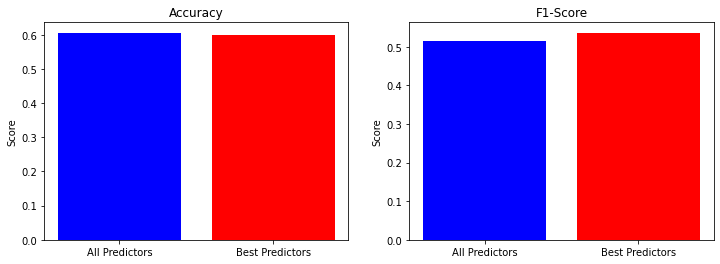

In [31]:
# compare the results of model with all features to model with fewer features
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].bar(['All Predictors', 'Best Predictors'], 
          [best_model.score(X_train, y_train), clf_trim.score(X_train_best_features, y_train)], 
          color=['b', 'r'])

ax[1].bar(['All Predictors', 'Best Predictors'], 
          [f1_score(y_train, best_model.predict(X_train)), f1_score(y_train, clf_trim.predict(X_train_best_features))], 
          color=['b', 'r'])

ax[0].set(title='Accuracy', ylabel='Score')
ax[1].set(title='F1-Score', ylabel='Score')

print(f'All Predictor Variables:  {len(best_model.coef_[0, :])}')
print(f'Best Predictor Variables: {len(clf_trim.coef_[0, :])}')

plt.show()

After running grid search cross validation we identified the best C hyper-tuning parameter to be 10 with l2 regularization. Using these hyper-tuning parameters we identified the top 40 features that had the most significant impact on the model based on their coefficients. We re-trained the logistic regression model using only these 40 features and compared the accuracy and F1-score to that of the original model with 101 variables. The accuracy of the second model on the trained data is about the same as the accuracy of the original model, while the F1-score of the second model is about .02 higher than the F1-score of the original model. Due to this increase in performance we will stick with the second model (40 features) and moving forward.

## 6. Analyze Model Performance on Training Data

In [33]:
len(y_train)

48041

Threshold = 0.5


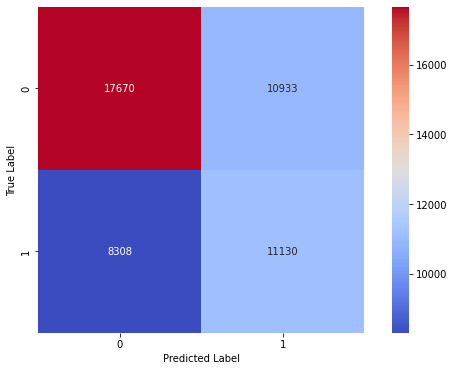

              precision    recall  f1-score   support

           0       0.68      0.62      0.65     28603
           1       0.50      0.57      0.54     19438

    accuracy                           0.60     48041
   macro avg       0.59      0.60      0.59     48041
weighted avg       0.61      0.60      0.60     48041



In [32]:
# make predictions for training data

y_pred = clf_trim.predict(X_train_best_features)
#y_pred = best_model.predict(X_train)

# create confusion matrix and classification report
fig, ax = plt.subplots(figsize=(10, 6))
mat = confusion_matrix(y_train, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='coolwarm', xticklabels=[0, 1], yticklabels=[0, 1])
ax.set(xlabel='Predicted Label')
ax.set(ylabel='True Label')
print('Threshold = 0.5')
plt.show()
print(classification_report(y_train, y_pred))

Threshold = 0.4


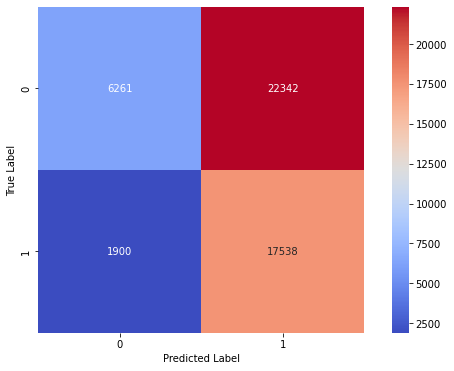

              precision    recall  f1-score   support

           0       0.77      0.22      0.34     28603
           1       0.44      0.90      0.59     19438

    accuracy                           0.50     48041
   macro avg       0.60      0.56      0.47     48041
weighted avg       0.63      0.50      0.44     48041



In [34]:
y_pred = np.where(clf_trim.predict_proba(X_train_best_features)[:,1] > .4, 1, 0)
#y_pred = np.where(best_model.predict_proba(X_train)[:,1] > .4, 1, 0)

# create confusion matrix

fig, ax = plt.subplots(figsize=(10, 6))
mat = confusion_matrix(y_train, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='coolwarm', xticklabels=[0, 1], yticklabels=[0, 1])
ax.set(xlabel='Predicted Label')
ax.set(ylabel='True Label')
print('Threshold = 0.4')
plt.show()
print(classification_report(y_train, y_pred))

Threshold = 0.6


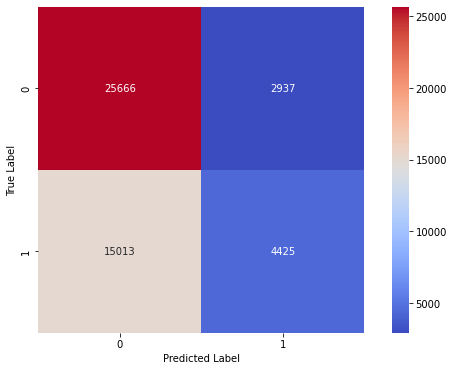

              precision    recall  f1-score   support

           0       0.63      0.90      0.74     28603
           1       0.60      0.23      0.33     19438

    accuracy                           0.63     48041
   macro avg       0.62      0.56      0.54     48041
weighted avg       0.62      0.63      0.57     48041



In [35]:
y_pred = np.where(clf_trim.predict_proba(X_train_best_features)[:,1] > .6, 1, 0)
#y_pred = np.where(best_model.predict_proba(X_train)[:,1] > .6, 1, 0)

# create confusion matrix

fig, ax = plt.subplots(figsize=(10, 6))
mat = confusion_matrix(y_train, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='coolwarm', xticklabels=[0, 1], yticklabels=[0, 1])
ax.set(xlabel='Predicted Label')
ax.set(ylabel='True Label')
print('Threshold = 0.6')
plt.show()
print(classification_report(y_train, y_pred))

After analyzing model performance on the training data at various threshold, it appears that a 0.6 threshold yields a slightly higher accuracy than the default 0.5 threshold:
- Threshold: 0.5 Accuracy: .60
- Threshold: 0.4 Accuracy: .50
- Threshold: 0.6 Accuracy: .63

But at the cost of a much lower F1-score:
- Threshold: 0.5 F1-Score: .54
- Threshold: 0.4 F1-Score: .59
- Threshold: 0.6 F1-Score: .33

May be business analyst who has domain knowledge could determine which is more important here - catching more at-risk patients for re-admission at the cost of a larger false positive rate, or maximizing overall accuracy. Given the slight decline in accuracy for a much higher F1-score though, we will consider the 0.5 threshold to be the best performer.

## 7. Analyze Model Performance on Testing Data

In [ ]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

In [ ]:
# predict the target probabilities
train_probs = clf_trim.predict_proba(X_train_best_features)[:,1]
train_probs

# define a range of thresholds
thresholds = np.arange(0, 1.05, 0.05)

# initialize the accuracy and f1_score lists
accuracies = []
f1_scores = []

# loop through the thresholds
for threshold in thresholds:
    # classify the target based on the threshold
    train_predictions = (train_probs >= threshold).astype(int)

    accuracy = accuracy_score(y_train, train_predictions)
    _f1_score = f1_score(y_train, train_predictions)

    # append the accuracy and f1_score to the lists
    accuracies.append(accuracy)
    f1_scores.append(_f1_score)

# plot the accuracy and f1_score as a function of the threshold
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# select the threshold that maximizes the accuracy
best_threshold = thresholds[np.argmax(accuracies)]
print("Best Threshold:", best_threshold)

# classify the target based on the best threshold
train_predictions = (train_probs >= best_threshold).astype(int)

# calculate the accuracy of the model
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy (Train):", accuracy)

In [ ]:
#https://www.statology.org/f1-score-in-python/
import numpy as np
from sklearn.metrics import f1_score

#define array of actual classes
actual = np.repeat([1, 0], repeats=[160, 240])

#define array of predicted classes
pred = np.repeat([1, 0, 1, 0], repeats=[120, 40, 70, 170])

#calculate F1 score
f1_score(actual, pred)

0.6857142857142857